In this task, we will create a visualization showing a ranking of the dishes for a Yelp cuisine of our choice. We may use the dish list we have provided, the list based on our annotations from Task 3 (or a subset of that list), or any other list for other cuisines. We might find it more interesting to work on a cuisine for which we can recognize many dishes than one with only a few dish names that we recognize.

There are many ways to approach this task; the main challenge will be how to create the ranking. We can devise our own method or use other methods we have learned in the Text Retrieval MOOC. The simplest approach can be to simply count how many times a dish is mentioned in all the reviews of restaurants of a particular cuisine, but we are encouraged to explore how to improve over this simple approach, e.g., by considering ratings of reviews or even sentiment of specific sentences that mention a dish. Even if we just try this simple approach, we may still need to consider options of counting dish mentions based on the number of reviews vs. the number of restaurants, so keep this question in mind: What do you think is the best way of ranking dishes for a cuisine? This is an open research question, but your exploration may help us better understand it.  


**Step 1: Frequency Count to Select Top 50 Dishes**  
Count mentions for each dish in the American cuisine reviews and select the top 100 dishes.  

**Step 3: Visualize Rating Distribution for Each Dish**  
For each of the top 50 dishes, gather review ratings and create a visualization showing how frequently each rating (e.g., 1 to 5 stars) is given to the dish.  

**Step 2: Weighted Frequency by Rating**  
Calculate a weighted frequency for each dish, where each mention is multiplied by the rating.  

**Step 4: Sentiment Analysis on Dish Mentions**  
Analyze sentiment for sentences mentioning each dish and add sentiment scores to your ranking.

In [35]:
import json
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re

In [2]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load american dish
dish_list = '/content/drive/MyDrive/Data Mining Project UIUC/task4/American Cuisine-Dishes.txt'

In [4]:
# Function to load and filter businesses with category "American (New)"

def filter_businesses_by_category(file_path, category):
    american_business_ids = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            business = json.loads(line)
            if 'categories' in business and category in business['categories']:
                american_business_ids.append(business['business_id'])
    return american_business_ids

In [5]:
# Define the file path and target category
business_file_path = '/content/drive/MyDrive/Data Mining Project UIUC/dataset/yelp_academic_dataset_business.json'
target_category = 'American (New)'
american_business_ids = filter_businesses_by_category(business_file_path, target_category)

# Check the number of businesses found
print(f"Number of businesses with category '{target_category}': {len(american_business_ids)}")

Number of businesses with category 'American (New)': 1058


Now that we have the american_business_ids, then we have to filter the reviews using these IDs.

In [6]:
# Function to filter reviews for American (New) cuisine based on business IDs
def filter_reviews_with_ratings(file_path, business_ids):
    american_reviews = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            review = json.loads(line)
            if review['business_id'] in business_ids:
                american_reviews.append({
                    'text': review['text'],
                    'rating': review['stars'],  # Include the rating here
                })
    return american_reviews

# Filter and preprocess the reviews for American (New) cuisine
reviews_file_path = '/content/drive/MyDrive/Data Mining Project UIUC/dataset/yelp_academic_dataset_review.json'
american_reviews_with_ratings = filter_reviews_with_ratings(reviews_file_path, american_business_ids)

# Check sample reviews
print(f"Number of reviews for American (New): {len(american_reviews_with_ratings)}")
print("Sample reviews with ratings:", american_reviews_with_ratings[:3])

Number of reviews for American (New): 94183
Sample reviews with ratings: [{'text': 'May be one of Middleton\'s best kept secrets... I had run past Paul\'s on numerous mornings and always figured the illumated "Open" sign was an oversight.\n\nTurns out they really are open at 7am each morning, and that they do indeed serve breakfast, including a prime rib breakfast on Sundays! While I haven\'t had breakfast from Paul\'s yet, I can confirm that it smells great!\n\nWe did enjoy a few rounds of drinks while at Paul\'s last night, and really had a good time.  The establishment is smoke-free (a HUGE bonus in our book), and is laid out in such a manner that the place doesn\'t feel crowded, even when it\'s busy.\n\nThe service was top notch; we never waited or wanted for anything, and we enjoyed watching the cook prepare a wide variety of bar fare with impeccible precision and ease. \n\nThe chicken tenders looked amazing, as did the bacon cheeseburgers with grilled onions. Portions were astron

In [7]:
# Save the filtered reviews with ratings to a new JSON file
with open('american_reviews_with_ratings.json', 'w', encoding='utf-8') as file:
    json.dump(american_reviews_with_ratings, file, ensure_ascii=False, indent=4)

**Step 1: Frequency Count to Select Top 50 Dishes**

In [8]:
# Function to load dish names from a text file
def load_dish_list(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dishes = [line.strip() for line in file]  # Strip whitespace and newline characters
    return dishes

# Load the dish list
dish_list_file_path = '/content/drive/MyDrive/Data Mining Project UIUC/task4/American Cuisine-Dishes.txt'
dish_list = load_dish_list(dish_list_file_path)

In [9]:
def count_dish_mentions(reviews, dish_list):
    dish_counter = Counter()
    for review in reviews:
        text = review['text'].lower()
        for dish in dish_list:
            if dish.lower() in text:
                dish_counter[dish] += 1
    return dish_counter


# Apply this to the American cuisine reviews
dish_counts = count_dish_mentions(american_reviews_with_ratings, dish_list)

# Convert the counts to a DataFrame for visualization
dish_df = pd.DataFrame(dish_counts.items(), columns=['dish', 'count']).sort_values(by='count', ascending=False)
dish_df.head(10)

,dish,count
12,rice,19553
8,cheese,16436
1,chicken,14583
4,burger,12682
45,appy,11212
34,bread,10428
36,tart,10389
24,ale,10201
42,egg,8914
18,potato,8876


In [10]:
print("Total dishes are:", len(dish_df))

Total dishes are: 555


**Step 2: Count Average Rating for Each Dish**

In [11]:
# Dictionary to hold rating counts for each dish
dish_ratings = defaultdict(lambda: [0, 0, 0, 0, 0])  # Initialize for 1-5 stars

# Calculate the rating distribution for each dish
for review in american_reviews_with_ratings:
    review_text = review['text'].lower()
    rating = review['rating']
    for dish in dish_list:
        if dish.lower() in review_text:
            dish_ratings[dish][rating - 1] += 1  # Adjust index for 1-5 stars

# Convert to DataFrame for easy manipulation and visualization
rating_distribution_df = pd.DataFrame([
    {'dish': dish, '1_star': ratings[0], '2_star': ratings[1], '3_star': ratings[2],
     '4_star': ratings[3], '5_star': ratings[4]}
    for dish, ratings in dish_ratings.items()
])

In [12]:
# Calculate the average star rating for each dish
rating_distribution_df['average_star'] = (
    rating_distribution_df['1_star'] * 1 +
    rating_distribution_df['2_star'] * 2 +
    rating_distribution_df['3_star'] * 3 +
    rating_distribution_df['4_star'] * 4 +
    rating_distribution_df['5_star'] * 5
) / (
    rating_distribution_df['1_star'] +
    rating_distribution_df['2_star'] +
    rating_distribution_df['3_star'] +
    rating_distribution_df['4_star'] +
    rating_distribution_df['5_star']
)

In [13]:
rating_distribution_df.head()

,dish,1_star,2_star,3_star,4_star,5_star,average_star
0,onion rings,41,55,115,225,158,3.680135
1,chicken,717,1338,2451,5452,4625,3.818076
2,fries,464,1003,1750,3326,2274,3.674039
3,onions,87,176,326,827,543,3.797856
4,burger,674,1302,2263,4614,3829,3.758713


In [14]:
rating_distribution_df

,dish,1_star,2_star,3_star,4_star,5_star,average_star
0,onion rings,41,55,115,225,158,3.680135
1,chicken,717,1338,2451,5452,4625,3.818076
2,fries,464,1003,1750,3326,2274,3.674039
3,onions,87,176,326,827,543,3.797856
4,burger,674,1302,2263,4614,3829,3.758713
...,...,...,...,...,...,...,...
550,gummies,0,1,1,2,1,3.600000
551,blizzards,0,0,1,1,0,3.500000
552,sauerbraten,0,0,0,1,0,4.000000
553,biloxi,0,4,5,14,16,4.076923


In [15]:
# Save the Dataframe

rating_distribution_df.to_csv('rating_distribution_df.csv', index=False)

**Step 3: Visualize the Top 50 Dishes by Count and Star Distribution for Top 20 Dishes**

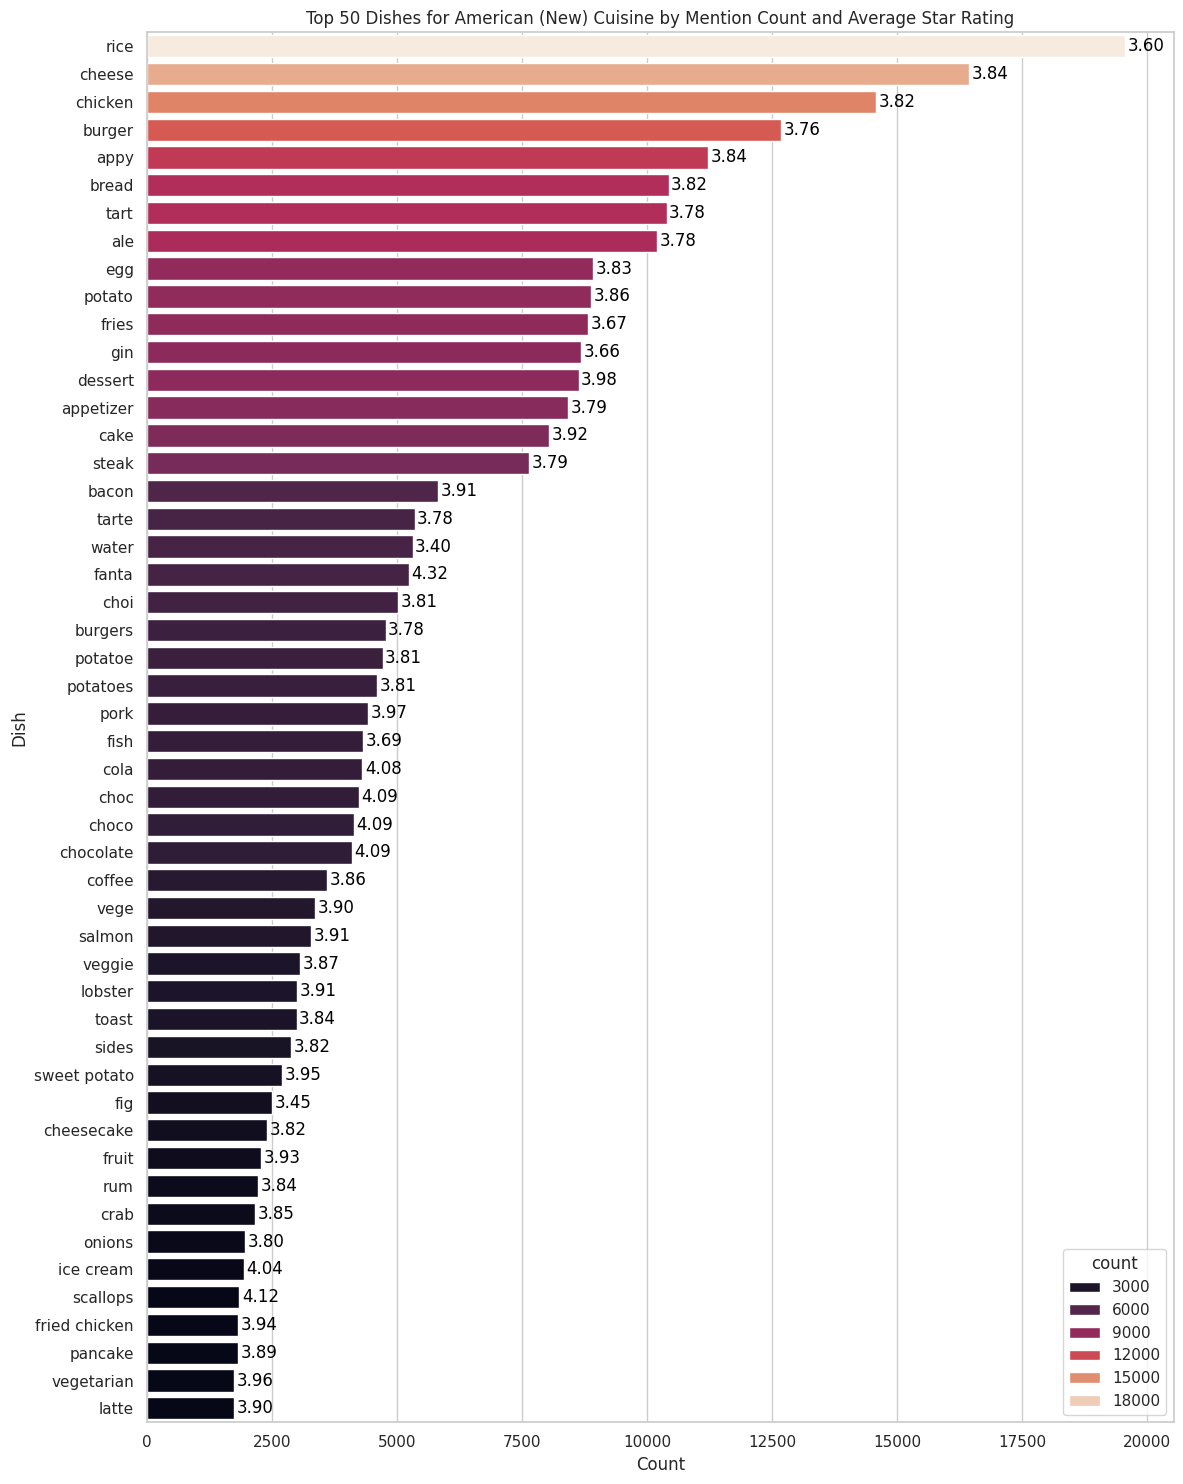

In [24]:
# Ensure we have the top 50 dishes sorted by count
top_50_dishes_df = dish_df.head(50)

# Reset index to ensure 'dish' is a regular column, not an index
top_50_dishes_df = top_50_dishes_df.reset_index(drop=True)
rating_distribution_df = rating_distribution_df.reset_index(drop=True)

# Confirm 'dish' column data type and convert to string if needed
top_50_dishes_df['dish'] = top_50_dishes_df['dish'].astype(str)
rating_distribution_df['dish'] = rating_distribution_df['dish'].astype(str)

# Merge DataFrames again
merged_df = pd.merge(
    top_50_dishes_df,
    rating_distribution_df[['dish', '1_star', '2_star', '3_star', '4_star', '5_star', 'average_star']],
    on='dish',
    how='left'
)

# Proceed with plotting if the merge is successful
plt.figure(figsize=(12, 15))
sns.set(style="whitegrid")
sns.barplot(x='count', y='dish', data=merged_df, palette="rocket", hue='count')

# Annotate with average star rating
for index, row in merged_df.iterrows():
    plt.text(row['count'] + 50, index, f'{row["average_star"]:.2f}', color='black', va="center")

plt.xlabel('Count')
plt.ylabel('Dish')
plt.title('Top 50 Dishes for American (New) Cuisine by Mention Count and Average Star Rating')
plt.tight_layout()
plt.show()

Based on the visualization of the top 50 dishes for American (New) cuisine by mention count and average star rating, here are some key insights:

**1. Most Popular Dishes by Mention Count**:  
Rice, Cheese, and Chicken are the top three most mentioned dishes, indicating that these items are highly popular and frequently reviewed within this cuisine.
Other dishes like Burger, Appy, and Bread also have high mention counts, suggesting they are staple items in American (New) cuisine.  

**2. Average Star Ratings Across Dishes**:  
Fanta and Scallops received the highest average star ratings, with 4.32 and 4.12 respectively. These items may be associated with positive experiences among reviewers, as they stand out for their higher ratings.
Dishes like Chocolate, Ice Cream, and Cola also have high average ratings, above 4.0, indicating they are well-liked.
Items such as Water have a surprisingly low average rating of 3.40, suggesting that while popular, they may not be associated with positive dining experiences.  

**3. Distribution of Mention Count vs. Average Rating**:  
High mention counts do not necessarily correlate with high ratings. For example, Rice has one of the highest mention counts but a moderate average rating of 3.60.
Conversely, Scallops has a high average rating but a lower mention count, suggesting it may be highly regarded by a smaller group of reviewers.  

**4. Variety in Popular Dishes**:  
The list includes a mix of both entrees (e.g., Steak, Burger) and side dishes/snacks (e.g., Fries, Cheese). This suggests that American (New) cuisine reviews cover a broad range of meal types, indicating varied consumer interests.
Dessert items like Chocolate, Cheesecake, and Ice Cream appear frequently, suggesting a strong preference for sweet dishes in American dining experiences.  

**5. Opportunities for Improvement**:  
Items with moderate ratings but high mentions, such as Rice and Chicken, might benefit from further quality enhancements, as their popularity could provide a significant impact on customer satisfaction if improved.
Dishes with lower mention counts but high ratings, like Scallops and Fanta, might be leveraged for marketing or menu highlighting to attract more interest.  

This analysis provides a snapshot of consumer preferences and satisfaction within American (New) cuisine, with potential areas for menu refinement and marketing focus based on popularity and customer satisfaction indicators.

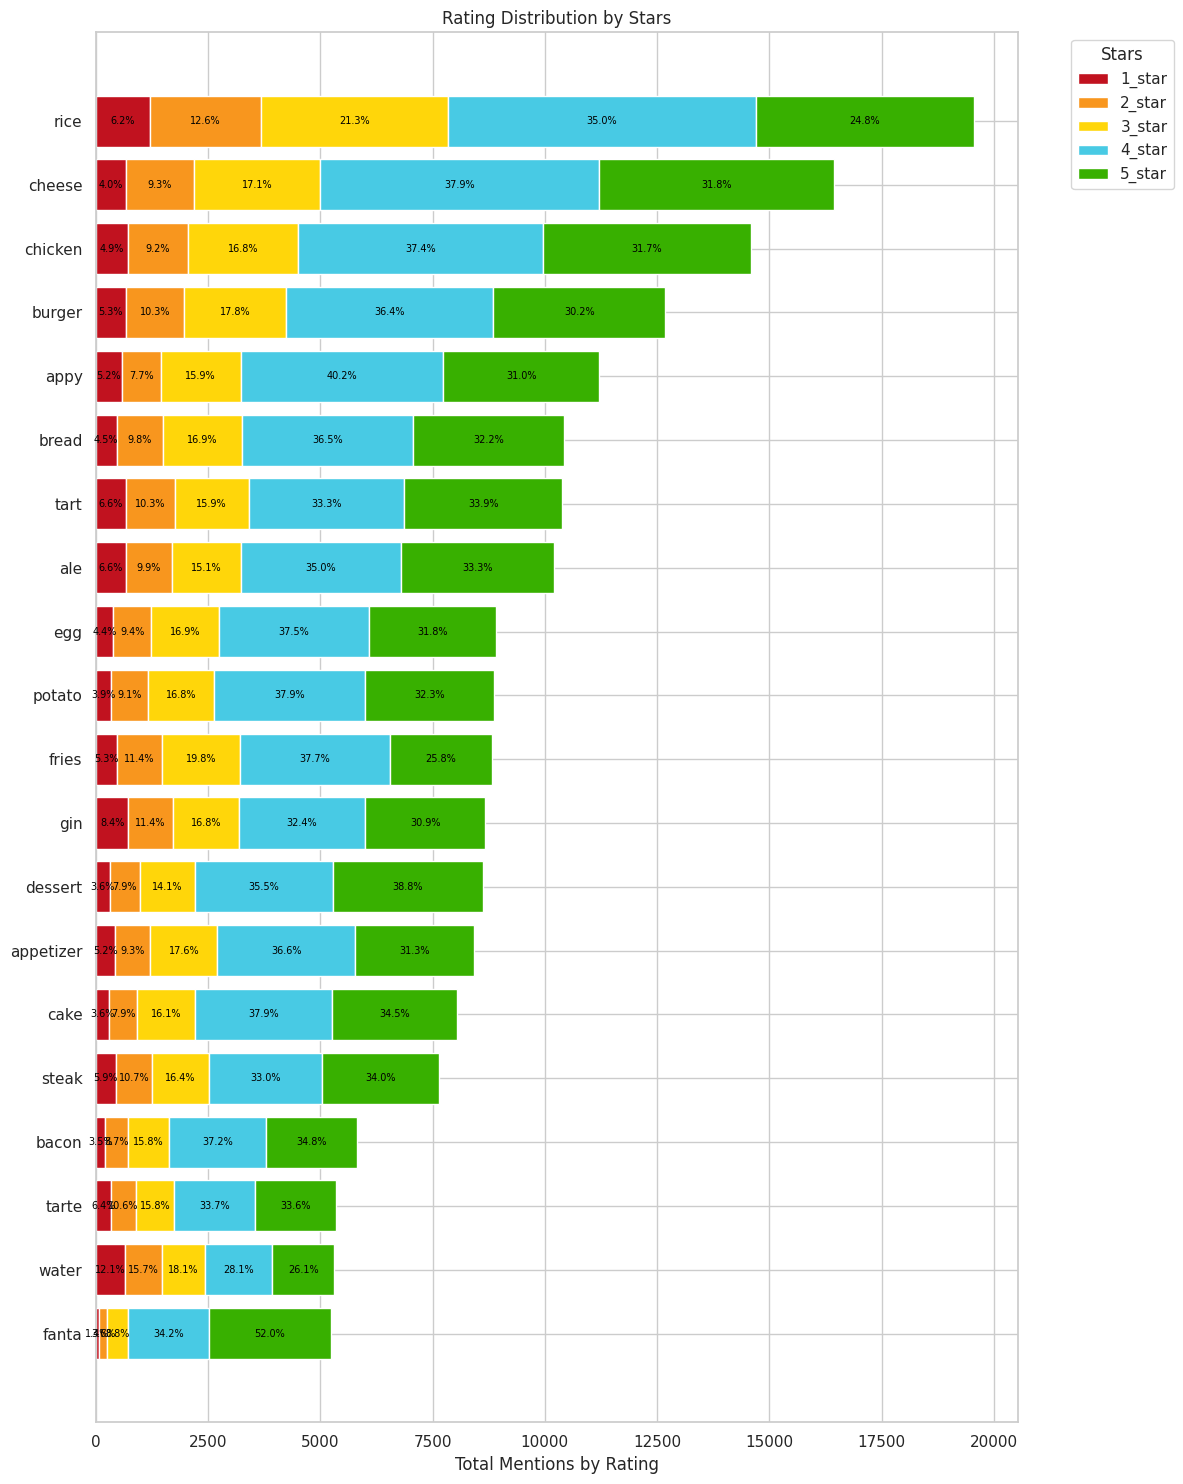

<Figure size 640x480 with 0 Axes>

In [34]:
# See the star distribution of top 20 dish
top_20_dishes_df = dish_df.head(20)

# Reset index to ensure 'dish' is a regular column, not an index
top_20_dishes_df = top_20_dishes_df.reset_index(drop=True)
rating_distribution_df = rating_distribution_df.reset_index(drop=True)

# Confirm 'dish' column data type and convert to string if needed
top_20_dishes_df['dish'] = top_20_dishes_df['dish'].astype(str)
rating_distribution_df['dish'] = rating_distribution_df['dish'].astype(str)

# Sorting `star_dist_df` based on `count_avg_df` order
top_20_merged = pd.merge(
    top_20_dishes_df,
    rating_distribution_df[['dish', '1_star', '2_star', '3_star', '4_star', '5_star', 'average_star']],
    on='dish',
    how='left'
)
top20_count_avg_df = top_20_merged[['dish', 'count', 'average_star']].sort_values(by='count')
top20_star_dist_df = top_20_merged[['dish', '1_star', '2_star', '3_star', '4_star', '5_star']]
top20_star_dist_df = top20_star_dist_df.set_index('dish').loc[top20_count_avg_df['dish']].reset_index()

# Set up a figure
fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111)
sns.set(style="whitegrid")

# Plot the Rating Distribution as a stacked bar chart
star_colors = ['#c1121f', '#f8961e', '#ffd60a', '#48cae4', '#38b000']
left = pd.Series([0] * len(top20_star_dist_df))

# Calculate percentage of each star for annotations
star_dist_df_total = top20_star_dist_df[['1_star', '2_star', '3_star', '4_star', '5_star']].sum(axis=1)
star_dist_df_pct = top20_star_dist_df[['1_star', '2_star', '3_star', '4_star', '5_star']].div(star_dist_df_total, axis=0)

for i, star in enumerate(['1_star', '2_star', '3_star', '4_star', '5_star']):
    ax.barh(top20_star_dist_df['dish'], top20_star_dist_df[star], left=left, label=star, color=star_colors[i])
    # Annotate each segment with percentage
    for j, (count, pct) in enumerate(zip(top20_star_dist_df[star], star_dist_df_pct[star])):
        if count > 0:
            ax.text(left[j] + count / 2, j, f'{pct:.1%}', ha='center', va='center', color='black', fontsize=7)
    left += top20_star_dist_df[star]

# Labels and legend for the right plot
ax.set_title('Rating Distribution by Stars')
ax.set_xlabel('Total Mentions by Rating')
ax.legend(title='Stars', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()
plt.savefig('top20_dish_ranking_visualization.png')

Here are some key insights based on the rating distribution by stars for the top 20 dishes in American (New) cuisine:

**1. Diverse Rating Distribution Across Popular Dishes**:  

Most dishes have a significant portion of 4 and 5-star ratings, showing overall customer satisfaction. For instance, Rice has 24.8% 5-star ratings and 35.0% 4-star ratings, making it a well-liked dish despite lower ratings in other categories.
Dishes like Fanta and Cake have higher percentages of 5-star ratings (52.0% and 34.5% respectively), indicating that these items receive a higher level of customer appreciation relative to other dishes.  

**2. Notable 1 and 2-Star Ratings**:  
Rice, Bread, and Steak have noticeable percentages of 1 and 2-star ratings, with Rice having 6.2% 1-star and 12.6% 2-star ratings. This could suggest inconsistencies in quality or that these dishes don’t meet certain customer expectations.
Egg, Bacon, and Water also show higher proportions of low ratings, with over 10% of ratings at the 1-star level for each. This might indicate areas for improvement to boost customer satisfaction.  

**3. High Variability in Customer Preferences**:  
Some dishes, such as Gin and Tart, exhibit a more balanced rating distribution across all star categories. This suggests a varied response, potentially reflecting differences in taste preferences or quality consistency.
Cheese and Chicken have a strong concentration in the 3 to 5-star range, with minimal lower ratings, which indicates a generally positive but occasionally mixed response.  

**4. Opportunities for Targeted Quality Improvement**:  
Dishes like Bread and Steak have both high mention counts and higher 1-star ratings. Targeted efforts to address common complaints could enhance overall satisfaction and reputation for these popular items.
For dishes like Appy and Burger, which are popular and have moderate to high 5-star ratings, maintaining quality should remain a priority to sustain customer satisfaction.  

**5. Strength in Dessert and Snack Items**:  
Dessert items like Cake, Appetizer, and Fries generally receive more favorable ratings, with a good proportion of 4 and 5-star ratings. This might indicate a preference for sweet and snack items in American (New) cuisine.
Fanta stands out with a substantial 52.0% in the 5-star category, suggesting a strong positive response for this beverage item.  

**6. Room for Promotion of Well-Received Items**:  
Dishes with a high proportion of 5-star ratings, such as Fanta, Cake, and Dessert, can be highlighted in promotional materials or menu recommendations as customer favorites.
Emphasizing dishes with a solid customer base and high satisfaction could reinforce the brand and attract new customers to try these well-rated items.  

This distribution highlights customer preferences and satisfaction levels across popular dishes, providing valuable insights for quality improvement and marketing strategies. By addressing low-rated items and promoting high-rated ones, restaurants can better meet customer expectations and enhance their dining experience.

**Step 4: Sentiment Analysis**

In [36]:
# Ensure VADER is downloaded if not already
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [38]:
# Initialize the VADER Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# Sample function to analyze sentiment for sentences mentioning each dish
def analyze_dish_sentiment(reviews, dishes):
    dish_sentiments = {dish: [] for dish in dishes}

    # Loop through each review
    for review in reviews:
        sentences = re.split(r'(?<=[.!?]) +', review['text'])  # Split into sentences
        for sentence in sentences:
            # Check if the dish is mentioned in the sentence
            for dish in dishes:
                if dish.lower() in sentence.lower():
                    # Analyze sentiment for the sentence
                    sentiment_score = sid.polarity_scores(sentence)['compound']
                    dish_sentiments[dish].append(sentiment_score)

    # Calculate the average sentiment for each dish
    dish_avg_sentiments = {dish: (sum(scores) / len(scores)) if scores else 0
                           for dish, scores in dish_sentiments.items()}
    return dish_avg_sentiments

# Assuming `american_reviews_with_ratings` contains review texts
# Example list of top 20 dishes for demonstration
top_20_dishes = ['rice', 'cheese', 'chicken', 'burger', 'appy', 'bread', 'tart', 'ale', 'egg', 'potato',
                 'fries', 'gin', 'dessert', 'appetizer', 'cake', 'steak', 'bacon', 'tarte', 'water', 'fanta']

# Analyze sentiment for top 20 dishes based on reviews
dish_avg_sentiments = analyze_dish_sentiment(american_reviews_with_ratings, top_20_dishes)

# Create a DataFrame with top 20 dishes and add sentiment scores
top_20_df = pd.DataFrame(top_20_dishes, columns=['dish'])
top_20_df['average_sentiment'] = top_20_df['dish'].map(dish_avg_sentiments)

# Display the updated DataFrame with sentiment scores
print(top_20_df)

         dish  average_sentiment
0        rice           0.320132
1      cheese           0.316617
2     chicken           0.302717
3      burger           0.325073
4        appy           0.630712
5       bread           0.326949
6        tart           0.308706
7         ale           0.317630
8         egg           0.301584
9      potato           0.398228
10      fries           0.352934
11        gin           0.320938
12    dessert           0.339772
13  appetizer           0.339314
14       cake           0.329204
15      steak           0.318305
16      bacon           0.291427
17      tarte           0.283769
18      water           0.215954
19      fanta           0.640371


Based on the analysis, we can conclude that there is generally an alignment between the average star ratings and sentiment analysis scores for the dishes. Here’s how they align:

**1. Dishes with High Star Ratings and Positive Sentiment**:   
Items like Fanta and Appy have both high average star ratings and high sentiment scores, indicating that they are not only popular but also evoke strong positive emotions among customers. This suggests that customers rate these dishes highly and express positive sentiments in their reviews.

**2. Dishes with Moderate Ratings and Sentiment**:   
Items such as Burger, Potato, and Fries have mid-range star ratings and sentiment scores. This indicates general satisfaction, with these dishes being liked but not necessarily standing out in terms of emotional impact.

**3. Dishes with Lower Ratings and Sentiment**:   
Water and Tarte have both lower star ratings and sentiment scores, suggesting that they might not resonate as positively with customers. This alignment indicates that the mixed or neutral emotions expressed in the reviews are consistent with the lower ratings.

In summary, while there may be minor variations, the average star ratings and sentiment scores tend to align, providing a consistent picture of customer satisfaction. High sentiment scores often correlate with higher star ratings, while lower sentiment scores align with lower ratings, offering a cohesive view of customer preferences and emotions.